<a href="https://colab.research.google.com/github/Joeychen80627/-Integrated-Energy-System-Multi-Load-Prediction-Report-Deep-Learning-/blob/main/Integrated_Energy_System_Multi_Load(deep).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrated Energy System Multi-Load Prediction Report(Deep Learning)

https://github.com/Joeychen80627/-Integrated-Energy-System-Multi-Load-Prediction-Report-Deep-Learning-

## Gather data, determine the method of data collection and provenance of the data (1 point)
## Identify a Deep Learning Problem (5 points)

## Project Theme and Overview
### Project Description:
This project aims to predict various load statuses in an integrated energy system—including electric load, cooling load, and heating load—to assist enterprises in optimizing energy dispatch and forecasting future trends. The data sources include electricity usage data from multiple buildings (including factories) within the corporate group, covering the period from January 1, 2020, to January 31, 2020. These are combined with meteorological data provided by the Central Weather Bureau, Ministry of Transportation and Communications, Taiwan. The weather data includes key parameters such as temperature, humidity, wind speed, solar zenith angle, and pressure. In addition, auxiliary features such as “Season” and “Daylight_Duration” are derived from the month to provide a more comprehensive representation of energy usage.

### Learning Type and Task Type:
* Learning Type: Deep Learning
* Task Type: 168-hour single-step prediction (Multi-output Binary Classification)
* The continuous energy load values (KW, CHWTON, HTmmBTU) are first converted to consistent units and then decomposed using Variational Mode Decomposition (VMD). Each decomposed component is trained separately and used for prediction.

### Model Selection:
* Multiple models are used, including CNN, CNN+LSTM, CNN+GRU, and CNN+BGRU. Time series data is processed using a single-step prediction mode with a 168-hour window as the input to forecast the value of the next time step.

##2. Project Goals and Motivation
### Project Goals:
* Identify key factors affecting energy loads (e.g., meteorological parameters and time-related variables) to serve as the basis for energy dispatch strategies.
* Predict short-term electric, cooling, and heating load statuses for multiple buildings, thereby balancing supply and demand, improving energy efficiency, and reducing carbon emissions.

### Motivation and Significance:
* In the context of actively promoting carbon reduction initiatives, accurate energy load prediction allows enterprises to adjust power supply strategies in advance and reduce energy waste.
* Integrated energy systems encompass multiple subsystems (electricity, cooling, heating, natural gas, etc.), and coordinated operation among these subsystems can maximize energy efficiency and support sustainable development.

## 3. Data Sources and Description
### Data Sources:
* Energy Data: Provided by the electricity-using units within the company's internal buildings (including factories) (data file: energy_data.xlsx).
* Meteorological Data: Acquired from the Central Weather Bureau, Ministry of Transportation and Communications, Taiwan. It includes parameters such as Temperature, Dew Point, Relative Humidity, Wind Speed, Solar Zenith Angle, and Pressure.

* APA Citation (Meteorological Data):

  Central Weather Bureau. (2023). Central Weather Bureau Meteorological Data [Data set]. Ministry of Transportation and Communications, Taiwan. Retrieved from https://www.cwb.gov.tw/

* Data Description:

  1. Time Range: January 1, 2023 – January 31, 2023

  2. Number of Records: Approximately 744 records (recorded hourly)

  3. Each Record Includes: More than 20 features (including both numerical and categorical)

### Data Types:

* Numerical: e.g., KW, CHWTON, HTmmBTU, Temperature, Relative Humidity, etc.

* Categorical: e.g., Cloud_Type, Season, Daylight_Duration, etc.

In [42]:
!pip install vmdpy --no-cache-dir
!pip install keras-tcn
!pip install torch-geometric
!pip install torchinfo



## Exploratory Data Analysis (EDA) – Inspect, Visualize, and Clean the Data (34 points)

The dataset consists of 8,784 hourly records with 35 columns, including date-time components (`Year`, `Month`, `Day`, `Hour`), load measurements (`KW`, `CHWTON`, `HTmmBTU`), environmental data (`Temperature`, `Dew Point`, `Wind Speed`, etc.), and derived carbon and energy equivalences.

### 1. Data Inspection & Feature Selection

We first examined the dataset's structure, confirming its completeness across an entire year (including a leap year with 8,784 hours). Feature selection was conducted separately for each of the three main load targets — electric load (`KW`), cooling load (`CHWTON`), and heating load (`HTmmBTU`). Selection was based on domain relevance and correlation strength. The features chosen were:

- **For KW**:  
  `['KW', 'CHWTON', 'Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction']`

- **For CHWTON**:  
  `['Month', 'Hour', 'KW', 'CHWTON', 'Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction', 'Wind_Speed']`

- **For HTmmBTU**:  
  `['HTmmBTU', 'Relative_Humidity', 'Solar_Zenith_Angle', 'Pressure']`

After merging, the unified feature set contained 14 unique variables, which serve as inputs to the predictive models.

### 2. Data Transformation and Cleaning

To better understand the relationships among energy loads, we applied a logarithmic transformation (`log1p`) to reduce skewness and stabilize variance for `KW`, `CHWTON`, and `HTmmBTU`.

We extracted the last full year of data (8,760 rows) and added a `datetime` column assuming hourly frequency starting from 2021-01-01. This enabled robust time-series analysis.

### 3. Correlation Analysis and Visualization

We conducted rolling Pearson correlation analysis using a 720-hour window (~30 days) to examine the dynamic relationships between:

- Electric vs Cooling Load  
- Electric vs Heating Load  
- Cooling vs Heating Load  

The resulting visualizations show seasonal variations in correlation**, highlighting how load dependencies shift over time.

Overall Pearson Correlation Coefficients (log-transformed):

- Electric–Cooling Load**: `0.795` (strong positive correlation)  
- Electric–Heating Load**: `-0.674` (moderate negative correlation)  
- Cooling–Heating Load**: `-0.902` (very strong negative correlation)  

These findings indicate that electric and cooling loads are closely aligned, while heating behaves oppositely, potentially due to seasonal temperature demands.


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vmdpy
import torch
import torch.nn as nn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Bidirectional, GRU
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tcn import TCN
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import os
from torchinfo import summary





In [12]:
file_path = '/content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Machine Learning: Theory & Hands-On Practice with Python/energy_data.xlsx'
df_raw = pd.read_excel(file_path)
df = df_raw.copy()

In [13]:
df.shape

(8784, 35)

In [14]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'day off', 'KW', 'KWS', 'CHWTON',
       'HTmmBTU', 'Combined_mmBTU', 'Combined_Tons_Carbon', 'KW_Houses',
       'KWlightbulbs', 'KWgalsgas', 'CHWTON_Houses', 'CHWTONlightbulbs',
       'CHWTONgalsgas', 'HTmmBTU_Houses', 'HTmmBTUlightbulbs',
       'HTmmBTUgalsgas', 'Total_Houses', 'Totallightbulbs', 'Totalgalsgas',
       'GHG', 'DOW', 'Temperature', 'Cloud_Type', 'Dew_Point',
       'Relative_Humidity', 'Solar_Zenith_Angle', 'Surface_Albedo', 'Pressure',
       'Precipitable_Water', 'Wind_Direction', 'Wind_Speed'],
      dtype='object')

In [16]:
import pandas as pd

# Unit conversion
ton_to_kw = 3.51685
mmBTU_to_kw = 293.07

if 'CHWTON' in df.columns:
    df['CHWTON'] *= ton_to_kw
if 'HTmmBTU' in df.columns:
    df['HTmmBTU'] *= mmBTU_to_kw

# Remove redundant columns
redundant_features = [
    'KW_Houses', 'KWlightbulbs', 'KWgalsgas',
    'CHWTON_Houses', 'CHWTONlightbulbs', 'CHWTONgalsgas',
    'HTmmBTU_Houses', 'HTmmBTUlightbulbs', 'HTmmBTUgalsgas',
    'Totallightbulbs', 'Totalgalsgas', 'KWS', 'Combined_mmBTU',
    'Combined_Tons_Carbon', 'GHG', 'Year', 'Total_Houses',
    'day off'
]
df.drop(columns=redundant_features, errors='ignore', inplace=True)

# Define target variables
target_vars = ['KW', 'CHWTON', 'HTmmBTU']

# Reset index
df.reset_index(drop=True, inplace=True)

# Convert all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Save each target variable individually
for target in target_vars:
    if target in df.columns:
        df[[target]].to_csv(f"{target}.csv", index=False)


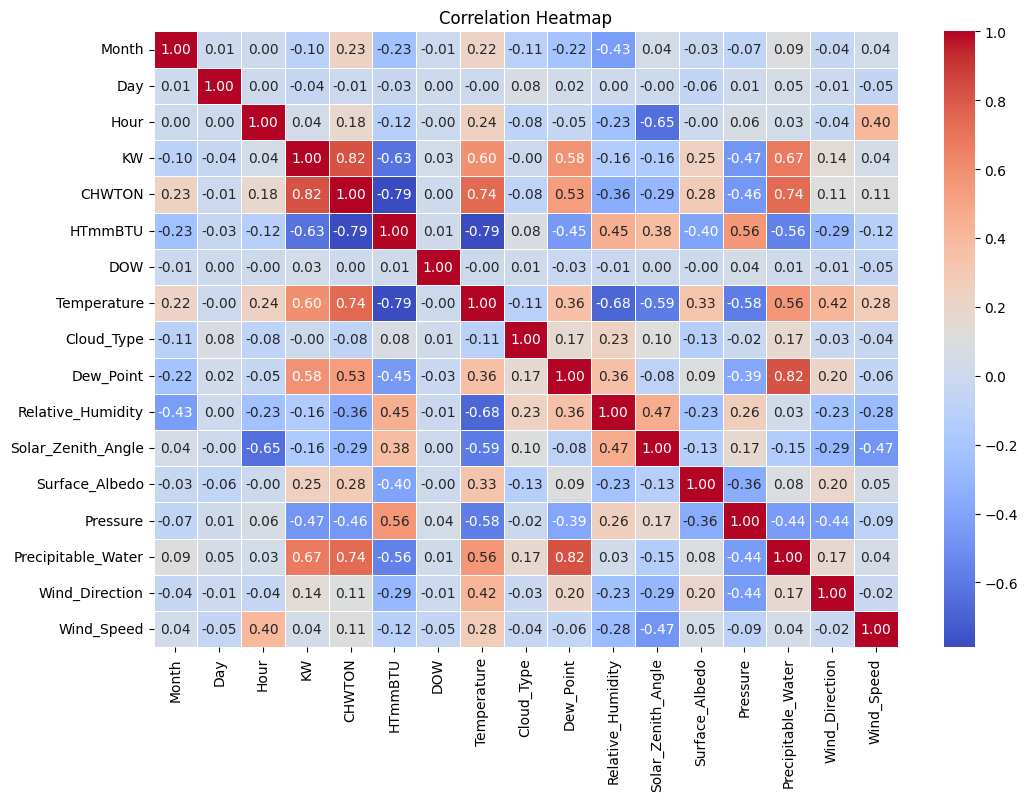

Selected features for KW: ['KW', 'CHWTON', 'Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction']
Selected features for CHWTON: ['Month', 'Hour', 'KW', 'CHWTON', 'Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction', 'Wind_Speed']
Selected features for HTmmBTU: ['HTmmBTU', 'Relative_Humidity', 'Solar_Zenith_Angle', 'Pressure']
All merged selected features: ['Pressure', 'Relative_Humidity', 'Month', 'KW', 'Precipitable_Water', 'HTmmBTU', 'Dew_Point', 'Wind_Speed', 'CHWTON', 'Temperature', 'Surface_Albedo', 'Wind_Direction', 'Hour', 'Solar_Zenith_Angle']


In [17]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Use a set to store all selected features to avoid duplicates
selected_features_all = set()

for target in target_vars:
    features = corr_matrix[target][corr_matrix[target] > 0.1].index.tolist()
    print(f"Selected features for {target}:", features)
    selected_features_all.update(features)

# Convert the set to a list and create a new DataFrame based on this list
selected_features_all = list(selected_features_all)
df_selected = df[selected_features_all].copy()

print("All merged selected features:", selected_features_all)

<ipython-input-31-766ac80b5fad>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  one_year['datetime'] = pd.date_range(start='2021-01-01', periods=len(one_year), freq='H')


Overall Electric-Cooling Load PCC: 0.7947628761489404
Overall Electric-Heating Load PCC: -0.6736992736847708
Overall Cooling-Heating Load PCC: -0.9017906084313154


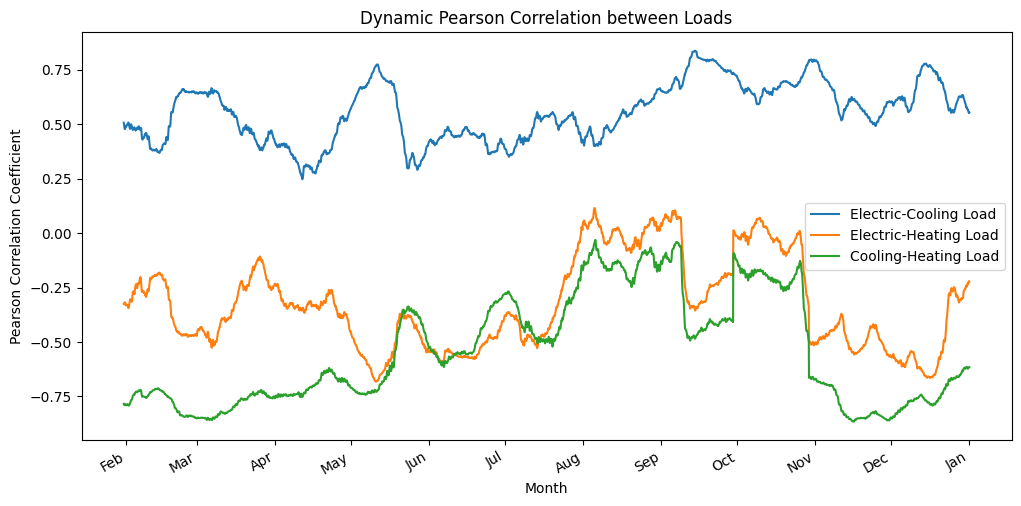

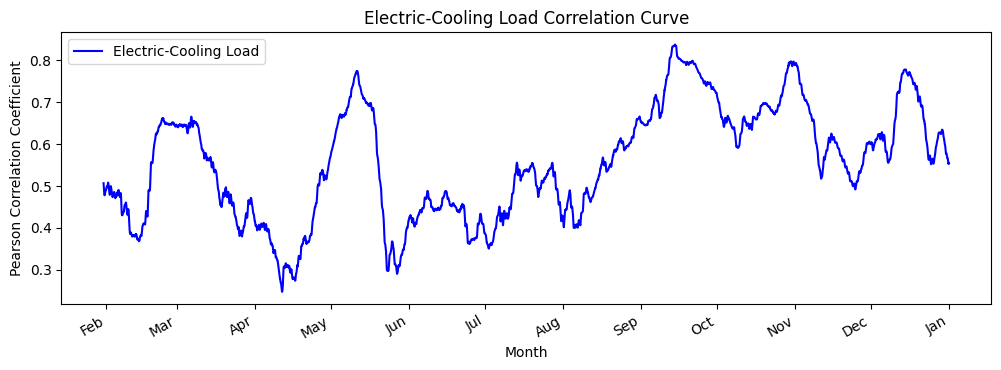

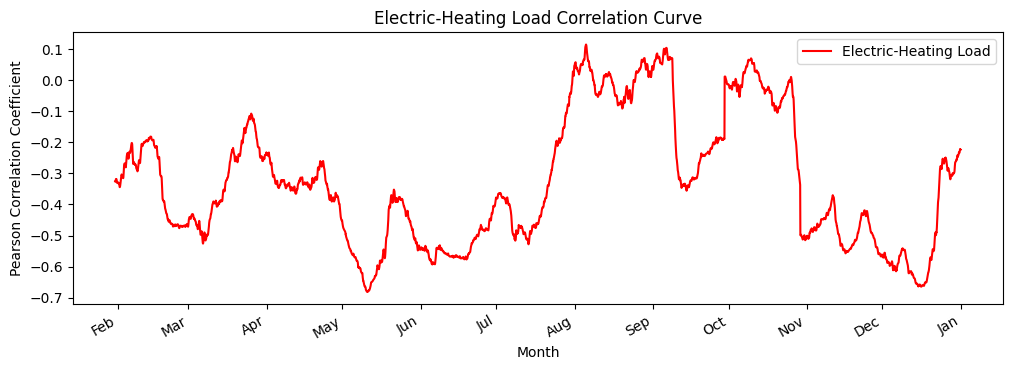

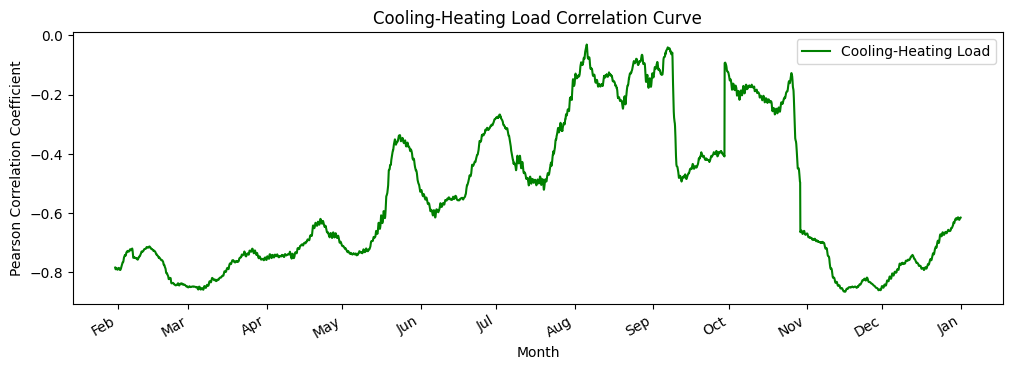

In [31]:
import matplotlib.dates as mdates

if len(df) >= 8760:
    one_year = df.tail(8760).reset_index(drop=True)

    # Add a datetime column: assuming data starts from 2021-01-01, with hourly frequency
    one_year['datetime'] = pd.date_range(start='2021-01-01', periods=len(one_year), freq='H')

    # Apply log transformation (using np.log1p, i.e., log(1+x))
    one_year['KW_log'] = np.log1p(one_year['KW'])
    one_year['CHWTON_log'] = np.log1p(one_year['CHWTON'])
    one_year['HTmmBTU_log'] = np.log1p(one_year['HTmmBTU'])

    window_size = 720  # Set rolling window size as needed
    # Compute rolling Pearson correlation coefficients after log transformation
    rolling_ec = one_year['KW_log'].rolling(window=window_size).corr(one_year['CHWTON_log'])
    rolling_eh = one_year['KW_log'].rolling(window=window_size).corr(one_year['HTmmBTU_log'])
    rolling_ch = one_year['CHWTON_log'].rolling(window=window_size).corr(one_year['HTmmBTU_log'])

    # 8.1 Plot all three sets of rolling correlation coefficients in the same figure (x-axis: datetime)
    plt.figure(figsize=(12, 6))
    plt.plot(one_year['datetime'], rolling_ec, label="Electric-Cooling Load")
    plt.plot(one_year['datetime'], rolling_eh, label="Electric-Heating Load")
    plt.plot(one_year['datetime'], rolling_ch, label="Cooling-Heating Load")
    plt.xlabel("Month")
    plt.ylabel("Pearson Correlation Coefficient")
    plt.title("Dynamic Pearson Correlation between Loads")
    plt.legend()
    # Set x-axis to display months
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gcf().autofmt_xdate()


    # 8.2 Plot individual correlation curves for each pair of loads

    # Electric-Cooling Load
    plt.figure(figsize=(12, 4))
    plt.plot(one_year['datetime'], rolling_ec, label="Electric-Cooling Load", color='blue')
    plt.xlabel("Month")
    plt.ylabel("Pearson Correlation Coefficient")
    plt.title("Electric-Cooling Load Correlation Curve")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gcf().autofmt_xdate()


    # Electric-Heating Load
    plt.figure(figsize=(12, 4))
    plt.plot(one_year['datetime'], rolling_eh, label="Electric-Heating Load", color='red')
    plt.xlabel("Month")
    plt.ylabel("Pearson Correlation Coefficient")
    plt.title("Electric-Heating Load Correlation Curve")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gcf().autofmt_xdate()


    # Cooling-Heating Load
    plt.figure(figsize=(12, 4))
    plt.plot(one_year['datetime'], rolling_ch, label="Cooling-Heating Load", color='green')
    plt.xlabel("Month")
    plt.ylabel("Pearson Correlation Coefficient")
    plt.title("Cooling-Heating Load Correlation Curve")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gcf().autofmt_xdate()

else:
    print("Insufficient data rows; unable to perform one-year dynamic correlation analysis.")

# Compute overall PCCs (based on log-transformed data)
overall_pcc_ec = one_year['KW_log'].corr(one_year['CHWTON_log'])
overall_pcc_eh = one_year['KW_log'].corr(one_year['HTmmBTU_log'])
overall_pcc_ch = one_year['CHWTON_log'].corr(one_year['HTmmBTU_log'])

# Output results
print("Overall Electric-Cooling Load PCC:", overall_pcc_ec)
print("Overall Electric-Heating Load PCC:", overall_pcc_eh)
print("Overall Cooling-Heating Load PCC:", overall_pcc_ch)


## Define Variational Mode Decomposition

* First, we introduce VMD (Variational Mode Decomposition). Since the goal of this study is to identify anomalies in electric load, chilled load, and thermal load, VMD can be used to decompose the signals into different modes, allowing for more detailed detection of abnormal noise.

* We will not go into the detailed explanation of each parameter at this stage. In short, the K value determines the number of Intrinsic Mode Functions (IMFs) to be decomposed. Selecting the optimal K value for each of the three load types is crucial.

* For the K values of each load type, we use the selected features for each signal to determine an appropriate K. The number of features helps guide the choice—if there are more features, a higher K value should be used. Therefore, the K value is set to 5 for electric load, 4 for thermal load, and 8 for chilled load.

In [19]:
# Common Parameter Definitions
alpha = 2000
tau = 0
DC = 0
init = 1
tol = 1e-7
K_values = range(1, 11)
target_vars = ['KW', 'CHWTON', 'HTmmBTU']

# Function Definitions: Compute MSRE
def compute_msre_for_signal(signal, K_values, alpha, tau, DC, init, tol):
    msre_list = []
    for K in K_values:
        # Perform VMD decomposition, returning u (modes), u_hat (frequency domain), omega (center frequencies)
        u, u_hat, omega = vmdpy.VMD(signal, alpha, tau, K, DC, init, tol)
        # Reconstruct the signal by summing all modes
        reconstructed_signal = np.sum(u, axis=0)
        # Compute Mean Square Reconstruction Error (MSRE) using L2 norm
        msre = (norm(signal - reconstructed_signal, 2)**2) / (norm(signal, 2)**2)
        msre_list.append(msre)
    return msre_list


# Function Definition: Perform VMD and Plot Results
def perform_and_plot_vmd(signal, signal_name, K):
    # Perform VMD decomposition
    u, u_hat, omega = vmdpy.VMD(signal, alpha, tau, K, DC, init, tol)
    # Plot VMD modes
    plt.figure(figsize=(12, 8))
    for i in range(K):
        plt.subplot(K, 1, i+1)
        plt.plot(u[i, :])
        plt.ylabel(f"Mode {i+1}")
        if i == 0:
            plt.title(f"{signal_name} - VMD Decomposition (K = {K})")
    plt.tight_layout()
    plt.show()
    return u, u_hat, omega

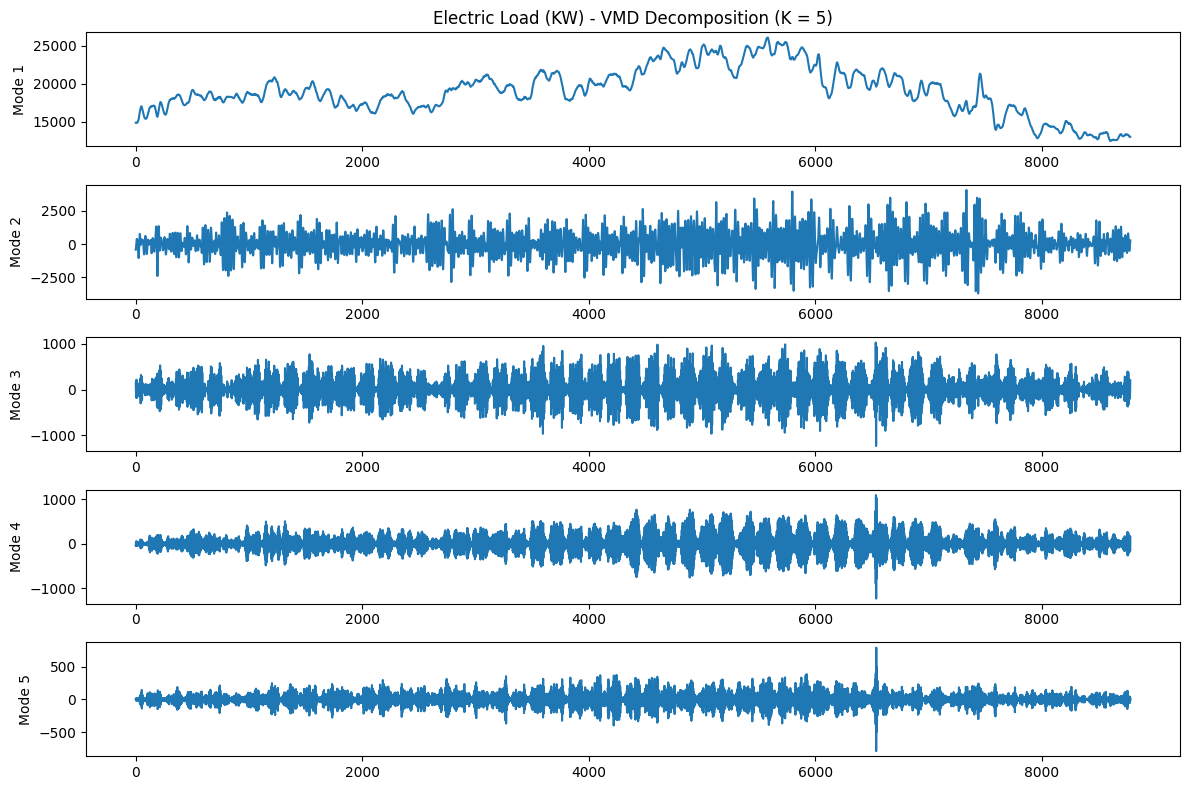

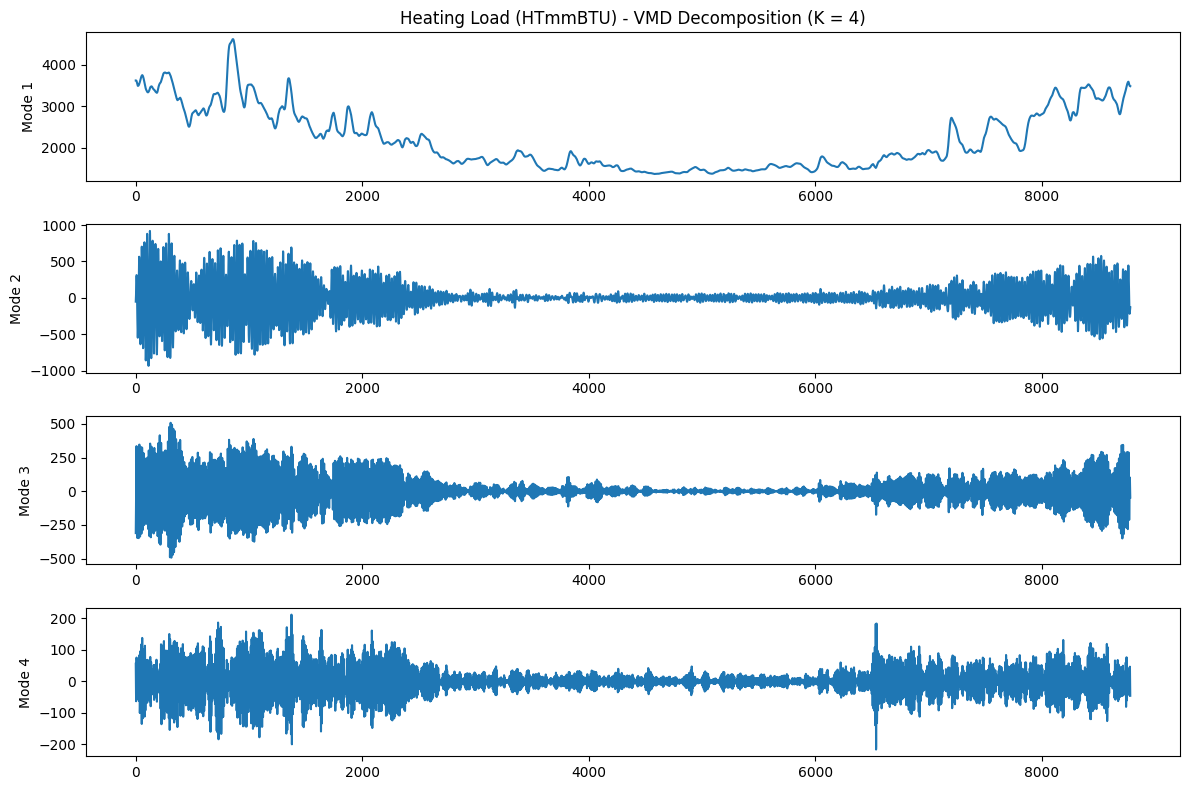

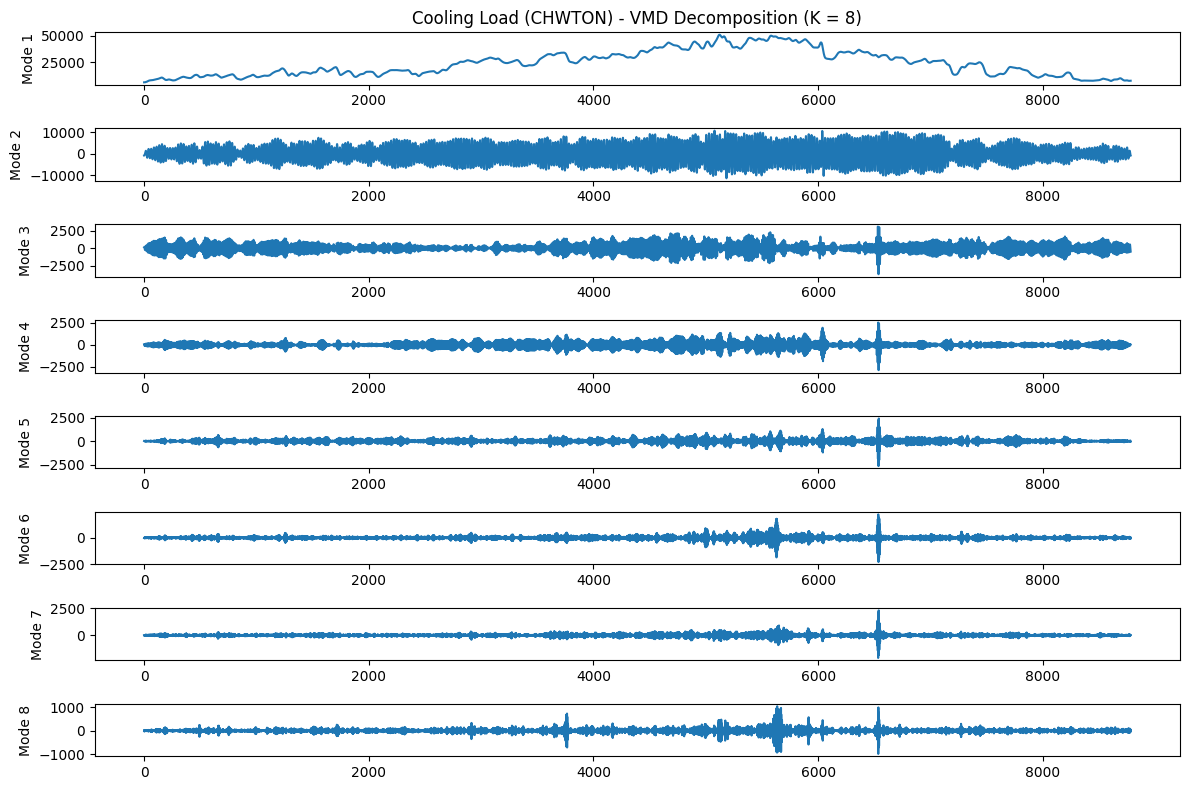

In [20]:
import pandas as pd

# Assume perform_and_plot_vmd is already defined
df_vmd = df.copy()

# Set the number of IMF modes for each type of load
K_elec = 5      # Number of IMFs for electric load
K_heating = 4   # Number of IMFs for heating load
K_cooling = 8   # Number of IMFs for cooling load

# Electric load (KW)
if 'KW' in df_vmd.columns:
    signal_elec = df_vmd['KW'].dropna().values
    u_elec, _, _ = perform_and_plot_vmd(signal_elec, "Electric Load (KW)", K_elec)

    df_vmd_elec = pd.DataFrame(u_elec.T)  # Transpose so IMFs become columns
    df_vmd_elec.columns = range(K_elec)   # Rename columns to 0, 1, 2, ...

    df_vmd_elec.to_csv('df_vmd_electric_load.csv', index=False)  # Do not keep the index


# Heating load (HTmmBTU)
if 'HTmmBTU' in df_vmd.columns:
    signal_thermal = df_vmd['HTmmBTU'].dropna().values
    u_thermal, _, _ = perform_and_plot_vmd(signal_thermal, "Heating Load (HTmmBTU)", K_heating)

    df_vmd_heating = pd.DataFrame(u_thermal.T)  # Transpose so IMFs become columns
    df_vmd_heating.columns = range(K_heating)   # Rename columns to 0, 1, 2, ...

    df_vmd_heating.to_csv('df_vmd_heating_load.csv', index=False)  # Do not keep the index


# Cooling load (CHWTON)
if 'CHWTON' in df_vmd.columns:
    signal_chilled = df_vmd['CHWTON'].dropna().values
    u_chilled, _, _ = perform_and_plot_vmd(signal_chilled, "Cooling Load (CHWTON)", K_cooling)

    df_vmd_cooling = pd.DataFrame(u_chilled.T)  # Transpose so IMFs become columns
    df_vmd_cooling.columns = range(K_cooling)   # Rename columns to 0, 1, 2, ...

    df_vmd_cooling.to_csv('df_vmd_cooling_load.csv', index=False)  # Do not keep the index


## Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)

## TimeSeriesDataset
* In single-step forecasting, our goal is to predict the load value at the next time point based on a fixed-length sequence of historical data. For example, using the past 168 hours of electric, cooling, and heating load data along with weather-related features to forecast the energy usage for the next hour. Single-step forecasting is suitable for short-term predictions, and we do not pursue multi-step forecasting in this study.

* We designed the TimeSeriesDataset(Dataset) class, which is a custom extension of PyTorch’s Dataset.
First, the selected common features are combined, and then the electric load, cooling load, and heating load are used as target values for training. The model reads a time sequence of 168 hours (equivalent to one week) at a time and uses it to predict the load value for the next hour.

In [21]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, seq_length=168):
        self.seq_length = seq_length
        self.features = features
        self.targets = targets
        # Number of available samples = total time steps - sequence length
        self.available_samples = len(features) - seq_length

    def __len__(self):
        """Return the number of available samples in the dataset"""
        return self.available_samples

    def __getitem__(self, idx):
        """
        Get a sample at the specified index.

        Args:
            idx (int): Index of the sample

        Returns:
            tuple: (historical feature sequence, target value at the next time step)
        """
        # Get historical feature sequence X
        X = self.features[idx:idx+self.seq_length]

        # Get the target value at the next time step y
        y = self.targets[idx+self.seq_length]

        return X, y


## load and process_data
* First, the code uses pd.read_csv to load the target variables (e.g., load), the features obtained from IMF decomposition, and the general meteorological and environmental feature data. Then, the IMF features and general features are combined into a complete feature matrix called all_features. Missing values in each column are filled with the median to ensure data integrity.

* To make the data more stable for the model, the StandardScaler is applied to standardize all features and target variables (mean = 0, standard deviation = 1). This ensures that features with different scales are comparable and helps accelerate model convergence.

* For data splitting, a sequential (non-random) method is used to divide the data into training, validation, and test sets according to specified proportions. Since this is time series data, the order must be preserved. Each dataset must also retain enough length to construct a historical sequence (seq_length, default is 168).

* Next, the previously defined TimeSeriesDataset class is used to create corresponding PyTorch datasets. These are then wrapped using DataLoader for efficient batch loading, which facilitates model training and inference. Finally, the function returns the data loaders, scalers, feature dimension, and the standardized raw feature data for later model usage.

In [22]:
def load_and_process_data(target_file, imf_files, common_features_file, seq_length=168, test_size=0.2, val_size=0.1):
    # Load target data
    targets_df = pd.read_csv(target_file)

    # Load IMF feature data
    imf_features = []
    for imf_file in imf_files:
        imf_df = pd.read_csv(imf_file)
        imf_features.append(imf_df)

    # Load common feature data
    common_features_df = pd.read_csv(common_features_file)

    # Merge all features
    all_features = pd.concat([common_features_df] + imf_features, axis=1)
    # Fill missing values: fill with the median of each column
    all_features = all_features.fillna(all_features.median())

    # Ensure data lengths are consistent
    min_length = min(len(targets_df), len(all_features))
    targets_df = targets_df.iloc[:min_length]
    all_features = all_features.iloc[:min_length]

    # Standardize feature and target data
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    features_scaled = feature_scaler.fit_transform(all_features)
    targets_scaled = target_scaler.fit_transform(targets_df)

    # Calculate the size of each dataset
    total_samples = min_length - seq_length
    test_samples = int(total_samples * test_size)
    val_samples = int(total_samples * val_size)
    train_samples = total_samples - test_samples - val_samples

    # Split the dataset sequentially
    train_features = features_scaled[:train_samples+seq_length]
    train_targets = targets_scaled[:train_samples+seq_length]
    val_features = features_scaled[train_samples:train_samples+val_samples+seq_length]
    val_targets = targets_scaled[train_samples:train_samples+val_samples+seq_length]
    test_features = features_scaled[train_samples+val_samples:]
    test_targets = targets_scaled[train_samples+val_samples:]

    # Create Dataset objects
    train_dataset = TimeSeriesDataset(train_features, train_targets, seq_length)
    val_dataset = TimeSeriesDataset(val_features, val_targets, seq_length)
    test_dataset = TimeSeriesDataset(test_features, test_targets, seq_length)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    dim = train_features.shape[1]
    return train_loader, val_loader, test_loader, feature_scaler, target_scaler,dim,features_scaled


## Create static adjacency matrix
* Creating a static adjacency matrix is primarily aimed at calculating the similarity between features based on the feature matrix, and generating the adjacency matrix according to the similarity. The main purpose of creating a static adjacency matrix is to establish a graph structure in Graph Neural Networks (GNNs), allowing the capture of relationships between nodes (features) in the graph. It is not suitable for CNNs. However, considering that my hybrid model uses LSTM, GRU, and BiGRU, it is beneficial for model optimization.

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
def create_static_adjacency_matrix(feature_scaled, method='cosine', k=None, threshold=None):
    # Ensure input is a NumPy array for processing
    if isinstance(feature_scaled, torch.Tensor):
        feature_np = feature_scaled.detach().cpu().numpy()
    else:
        feature_np = feature_scaled
    N = feature_np.shape[1]
    # Method : Cosine similarity
    if method == 'cosine':
        similarity = cosine_similarity(feature_np.T)
        adj_matrix = similarity

        # Optional: Apply threshold
        if threshold is not None:
            adj_matrix = (adj_matrix > threshold).astype(float)
    # Remove self-loops (diagonal elements)
    np.fill_diagonal(adj_matrix, 0)
    # Convert to PyTorch tensor
    return torch.tensor(adj_matrix, dtype=torch.float32)


In [24]:
def train_model(model, model_name, train_loader, val_loader, test_loader=None, epochs=50, learning_rate=0.001, target_scaler=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    results_dir = f"results_{model_name}"
    os.makedirs(results_dir, exist_ok=True)

    # Record training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()

        # Compute average loss
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rate'].append(learning_rate)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(results_dir, f'{model_name}_best.pth'))

    plot_training_history(history, os.path.join(results_dir, f'training_history_epoch_{epoch+1}.png'))

    # Save final model
    torch.save(model.state_dict(), os.path.join(results_dir, f'{model_name}_final.pth'))

    # Save history to CSV
    history_df = pd.DataFrame(history)
    history_df.to_csv(os.path.join(results_dir, 'training_history.csv'), index=False)

    # Evaluate on train and validation sets
    train_metrics, train_predictions = evaluate_model(model, train_loader, device, "Train Set", target_scaler)
    val_metrics, val_predictions = evaluate_model(model, val_loader, device, "Validation Set", target_scaler)

    metrics = {
        'train': train_metrics,
        'val': val_metrics
    }

    predictions = {
        'train': train_predictions,
        'val': val_predictions
    }

    # Evaluate on test set if provided
    if test_loader is not None:
        test_metrics, test_predictions = evaluate_model(model, test_loader, device, "Test Set", target_scaler)
        metrics['test'] = test_metrics
        predictions['test'] = test_predictions

    # Save metrics to CSV
    save_metrics_to_csv(metrics, os.path.join(results_dir, 'evaluation_metrics.csv'))
    save_predictions_to_csv(predictions, results_dir)

    # Plot predictions for test set
    if test_loader is not None:
        plot_predictions(test_predictions, os.path.join(results_dir, 'test_predictions.png'))

    return model, history, metrics, predictions

def evaluate_model(model, data_loader, device, dataset_name, target_scaler=None):
    model.eval()
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
            y_pred = model(X_batch)

            all_y_true.append(y_batch.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)

    if target_scaler is not None:
        y_true = target_scaler.inverse_transform(y_true)
        y_pred = target_scaler.inverse_transform(y_pred)

    metrics = {}
    target_dim = y_true.shape[1]

    # Overall metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics['overall'] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Metrics per target
    for i in range(target_dim):
        mse_i = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse_i = np.sqrt(mse_i)
        mae_i = mean_absolute_error(y_true[:, i], y_pred[:, i])
        r2_i = r2_score(y_true[:, i], y_pred[:, i])

        metrics[f'target_{i}'] = {
            'MSE': mse_i,
            'RMSE': rmse_i,
            'MAE': mae_i,
            'R2': r2_i
        }

    # Print results
    print(f"\n{dataset_name} Evaluation:")
    print(f"Overall MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    for i in range(target_dim):
        print(f"Target {i} - MSE: {metrics[f'target_{i}']['MSE']:.4f}, "
              f"RMSE: {metrics[f'target_{i}']['RMSE']:.4f}, "
              f"MAE: {metrics[f'target_{i}']['MAE']:.4f}, "
              f"R²: {metrics[f'target_{i}']['R2']:.4f}")

    predictions = {
        'y_true': y_true,
        'y_pred': y_pred
    }

    return metrics, predictions

def plot_training_history(history, save_path=None):
    """
    Plot training and validation loss over epochs
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def plot_predictions(predictions, save_path=None):
    """
    Plot prediction vs true values for each target
    """
    y_true = predictions['y_true']
    y_pred = predictions['y_pred']

    target_dim = y_true.shape[1]
    time_steps = np.arange(len(y_true))

    plt.figure(figsize=(15, 5 * target_dim))

    for i in range(target_dim):
        plt.subplot(target_dim, 1, i + 1)
        plt.plot(time_steps, y_true[:, i], 'b-', label='True')
        plt.plot(time_steps, y_pred[:, i], 'r-', label='Predicted')
        plt.title(f'Target {i} Prediction vs True')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def save_metrics_to_csv(metrics, save_path):
    """
    Save evaluation metrics to a CSV file
    """
    rows = []

    for dataset_name, dataset_metrics in metrics.items():
        for metric_name, metric_value in dataset_metrics['overall'].items():
            rows.append({
                'Dataset': dataset_name,
                'Target': 'Overall',
                'Metric': metric_name,
                'Value': metric_value
            })

        for target_key, target_metrics in dataset_metrics.items():
            if target_key != 'overall':
                for metric_name, metric_value in target_metrics.items():
                    rows.append({
                        'Dataset': dataset_name,
                        'Target': target_key,
                        'Metric': metric_name,
                        'Value': metric_value
                    })

    metrics_df = pd.DataFrame(rows)
    metrics_df.to_csv(save_path, index=False)

def save_predictions_to_csv(predictions, save_dir):
    """
    Save predictions to CSV files
    """
    for dataset_name, dataset_predictions in predictions.items():
        y_true = dataset_predictions['y_true']
        y_pred = dataset_predictions['y_pred']
        target_dim = y_true.shape[1]

        data = {}
        for i in range(target_dim):
            data[f'true_target_{i}'] = y_true[:, i]
            data[f'pred_target_{i}'] = y_pred[:, i]

        df = pd.DataFrame(data)
        df.to_csv(os.path.join(save_dir, f'{dataset_name}_predictions.csv'), index=False)


## Model
### Model Selection:
* For this analysis, we use four different deep learning models that combine CNNs with various types of recurrent neural networks (RNNs), specifically LSTM, GRU, and BiGRU. Each of these models has distinct advantages, depending on the nature of the data and the task at hand.

  1. CNN (Convolutional Neural Network): Primarily used for image and spatial data, CNNs are also highly effective in extracting temporal patterns from time-series data. However, CNNs alone may not capture long-term dependencies that are often present in sequential data like time-series.

  2. CNN + LSTM: Combining CNN with LSTM allows the model to leverage CNN's feature extraction capabilities for local patterns and LSTM's power to capture long-term dependencies. This combination is ideal for tasks where both spatial and temporal patterns need to be learned, such as in time-series forecasting.

  3. CNN + GRU: Similar to the CNN + LSTM model, the CNN + GRU combination uses CNN to extract spatial features and GRU to capture sequential dependencies. GRU is often preferred over LSTM in cases where the model needs to be more computationally efficient since GRUs are less complex and require fewer parameters than LSTMs.

  4. CNN + BiGRU: A more advanced version of the CNN + GRU model, BiGRU processes the data in both forward and backward directions, capturing context from both past and future time steps. This is particularly useful when the sequence contains dependencies that span both directions, such as in time-series data where future context is as important as past context.

### Experimental Setup:
* For each model, the input data consists of a sequence of time-series values (such as electric load, chilled load, and thermal load). The task is to predict the next value in the sequence based on the previous time steps. Each model is trained on the same training data, and the performance is evaluated based on key metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-Squared (R2).

### Performance Comparison:
  1. CNN: While the CNN can effectively extract local patterns in the time-series data, it might struggle with long-range dependencies, which are essential for accurate forecasting. Therefore, CNN alone might not perform as well as the combined models.

  2. CNN + LSTM: This model is expected to perform better than CNN alone due to the LSTM's ability to capture long-term dependencies in sequential data. It should show improvements in forecasting accuracy, especially for data with significant temporal patterns.

  3. CNN + GRU: This model should perform similarly to CNN + LSTM, but it is computationally more efficient. The GRU’s simpler structure might help in faster training and lower memory usage, but the model might sacrifice some performance in terms of long-term memory capabilities compared to LSTM.

  4. CNN + BiGRU: This model is expected to provide the best performance, as it captures both past and future dependencies in the data, which can be particularly useful for time-series forecasting. The BiGRU structure allows the model to better handle the bidirectional nature of time-series data, providing more accurate predictions.

In [33]:
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=3, cnn_layers=1, kernel_size=3, dropout_prob=0.3):
        super(CNN, self).__init__()
        self.cnn_layers = nn.ModuleList()
        # First CNN layer
        self.cnn_layers.append(
            nn.Sequential(
                nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
            )
        )
        # Additional CNN layers
        for _ in range(1, cnn_layers):
            self.cnn_layers.append(
                nn.Sequential(
                    nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size // 2),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
                )
            )
        self.dropout = nn.Dropout(dropout_prob)
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        # Input shape: [batch_size, seq_len, input_dim]
        x = x.permute(0, 2, 1)
        for cnn_layer in self.cnn_layers:
            x = cnn_layer(x)
        x = self.dropout(x)
        # Global average pooling (or take last timestep, depending on your use case)
        x = torch.mean(x, dim=2)
        output = self.fc(x)
        return output

In [34]:
from torchsummary import summary
import torch

model = CNN(input_dim=10, hidden_dim=32, output_dim=3, cnn_layers=2)
model.to('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, input_size=(168, 10))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 168]             992
       BatchNorm1d-2              [-1, 32, 168]              64
              ReLU-3              [-1, 32, 168]               0
         MaxPool1d-4              [-1, 32, 169]               0
            Conv1d-5              [-1, 32, 169]           3,104
       BatchNorm1d-6              [-1, 32, 169]              64
              ReLU-7              [-1, 32, 169]               0
         MaxPool1d-8              [-1, 32, 170]               0
           Dropout-9              [-1, 32, 170]               0
           Linear-10                    [-1, 3]              99
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.37
Params size (MB): 0.02
Estimated Total

In [ ]:
path = r"/content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Introduction to Deep Learning/SSV-VMD/"
target_file = path + 'target.csv'
imf_files = [path + 'imfs0.csv', path + 'imfs1.csv', path + 'imfs2.csv']
common_features_file = path + 'common_features.csv'

# Load and process data
train_loader, val_loader, test_loader, feature_scaler, target_scaler, input_dim, feature_scaled = load_and_process_data(
    target_file, imf_files, common_features_file
)

# Print dataset sizes
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

# 1. Create adjacency matrix using cosine similarity
adj_cosine = create_static_adjacency_matrix(feature_scaled, method='cosine', threshold=0.5)

# Initialize the model
model = CNN(input_dim)

# Train the model and get results
model, history, metrics, predictions = train_model(
    model=model,
    model_name="CNN",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=50,
    learning_rate=0.0005,
    target_scaler=target_scaler
)

Number of training samples: 6032
Number of validation samples: 861
Number of test samples: 1723
Epoch 1/50, Train Loss: 0.6954, Val Loss: 0.5218
Epoch 2/50, Train Loss: 0.8813, Val Loss: 0.5112
Epoch 3/50, Train Loss: 0.8405, Val Loss: 0.4273
Epoch 4/50, Train Loss: 0.8079, Val Loss: 0.4120
Epoch 5/50, Train Loss: 0.7735, Val Loss: 0.4052
Epoch 6/50, Train Loss: 0.7408, Val Loss: 0.3858
Epoch 7/50, Train Loss: 0.7078, Val Loss: 0.4080
Epoch 8/50, Train Loss: 0.6749, Val Loss: 0.4314
Epoch 9/50, Train Loss: 0.6437, Val Loss: 0.4801
Epoch 10/50, Train Loss: 0.6129, Val Loss: 0.5207
Epoch 11/50, Train Loss: 0.5836, Val Loss: 0.5477
Epoch 12/50, Train Loss: 0.5543, Val Loss: 0.5436
Epoch 13/50, Train Loss: 0.5262, Val Loss: 0.6415
Epoch 14/50, Train Loss: 0.5000, Val Loss: 0.6899
Epoch 15/50, Train Loss: 0.4740, Val Loss: 0.7225
Epoch 16/50, Train Loss: 0.4501, Val Loss: 0.7446
Epoch 17/50, Train Loss: 0.4302, Val Loss: 0.8891
Epoch 18/50, Train Loss: 0.4099, Val Loss: 0.8482
Epoch 19/50, 

In [35]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, layer_dim=2, output_dim=3,
                 cnn_layers=1, kernel_size=3, dropout_prob=0.3):
        super(CNN_LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim

        # CNN part
        self.cnn_layers = nn.ModuleList()

        # First convolutional layer
        self.cnn_layers.append(
            nn.Sequential(
                nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
            )
        )

        # Additional convolutional layers
        for i in range(1, cnn_layers):
            self.cnn_layers.append(
                nn.Sequential(
                    nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
                )
            )

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)

        # LSTM part
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Transpose input for CNN [batch_size, input_dim, seq_len]
        x_cnn = x.permute(0, 2, 1)

        # Pass through CNN layers
        for cnn_layer in self.cnn_layers:
            x_cnn = cnn_layer(x_cnn)

        # Transpose back for LSTM [batch_size, seq_len, hidden_dim]
        x_lstm = x_cnn.permute(0, 2, 1)

        # Apply dropout
        x_lstm = self.dropout(x_lstm)

        # LSTM layer
        h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).requires_grad_().to(x.device)
        c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).requires_grad_().to(x.device)

        # Forward propagate through LSTM
        lstm_out, (hn, cn) = self.lstm(x_lstm, (h0.detach(), c0.detach()))

        # Fully connected layer
        output = self.fc(lstm_out[:, -1, :])

        return output


In [45]:
model = CNN_LSTM(input_dim=10, hidden_dim=32, output_dim=3, cnn_layers=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
summary(model, input_size=(1, 168, 10))  # batch_size=1


Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [1, 3]                    --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 32, 169]              --
│    │    └─Conv1d: 3-1                  [1, 32, 168]              992
│    │    └─BatchNorm1d: 3-2             [1, 32, 168]              64
│    │    └─ReLU: 3-3                    [1, 32, 168]              --
│    │    └─MaxPool1d: 3-4               [1, 32, 169]              --
│    └─Sequential: 2-2                   [1, 32, 170]              --
│    │    └─Conv1d: 3-5                  [1, 32, 169]              3,104
│    │    └─BatchNorm1d: 3-6             [1, 32, 169]              64
│    │    └─ReLU: 3-7                    [1, 32, 169]              --
│    │    └─MaxPool1d: 3-8               [1, 32, 170]              --
├─Dropout: 1-2                           [1, 170, 32]              --
├─LSTM: 1-3

In [ ]:
path = r"/content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Introduction to Deep Learning/SSV-VMD/"
target_file = path + 'target.csv'
imf_files = [path + 'imfs0.csv', path + 'imfs1.csv', path + 'imfs2.csv']
common_features_file = path + 'common_features.csv'

# Load and process data
train_loader, val_loader, test_loader, feature_scaler, target_scaler, input_dim, feature_scaled = load_and_process_data(
    target_file, imf_files, common_features_file
)

# Print dataset sizes
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

# 1. Create adjacency matrix using cosine similarity
adj_cosine = create_static_adjacency_matrix(feature_scaled, method='cosine', threshold=0.5)

# Initialize the model
model = CNN_LSTM(input_dim)

# Train the model and get results
model, history, metrics, predictions = train_model(
    model=model,
    model_name="CNN-LSTM",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=50,
    learning_rate=0.0005,
    target_scaler=target_scaler
)

Number of training samples: 6032
Number of validation samples: 861
Number of test samples: 1723
Epoch 1/50, Train Loss: 0.5248, Val Loss: 1.0473
Epoch 2/50, Train Loss: 0.6926, Val Loss: 0.4168
Epoch 3/50, Train Loss: 0.3466, Val Loss: 0.2342
Epoch 4/50, Train Loss: 0.2300, Val Loss: 0.1582
Epoch 5/50, Train Loss: 0.1852, Val Loss: 0.1395
Epoch 6/50, Train Loss: 0.1487, Val Loss: 0.1328
Epoch 7/50, Train Loss: 0.1278, Val Loss: 0.1247
Epoch 8/50, Train Loss: 0.1133, Val Loss: 0.1189
Epoch 9/50, Train Loss: 0.1013, Val Loss: 0.0974
Epoch 10/50, Train Loss: 0.0901, Val Loss: 0.0830
Epoch 11/50, Train Loss: 0.0838, Val Loss: 0.0763
Epoch 12/50, Train Loss: 0.0770, Val Loss: 0.0734
Epoch 13/50, Train Loss: 0.0737, Val Loss: 0.0684
Epoch 14/50, Train Loss: 0.0694, Val Loss: 0.0662
Epoch 15/50, Train Loss: 0.0651, Val Loss: 0.0667
Epoch 16/50, Train Loss: 0.0647, Val Loss: 0.0653
Epoch 17/50, Train Loss: 0.0616, Val Loss: 0.0701
Epoch 18/50, Train Loss: 0.0587, Val Loss: 0.0664
Epoch 19/50, 

In [46]:
class CNN_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, layer_dim=2, output_dim=3,
                 cnn_layers=1, kernel_size=3, dropout_prob=0.3):
        super(CNN_GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim

        # CNN layers
        self.cnn_layers = nn.ModuleList()

        # First CNN layer
        self.cnn_layers.append(
            nn.Sequential(
                nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
            )
        )

        # Additional CNN layers
        for i in range(1, cnn_layers):
            self.cnn_layers.append(
                nn.Sequential(
                    nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size // 2),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
                )
            )

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)

        # GRU layer
        self.gru = nn.GRU(hidden_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Transpose for CNN: [batch_size, input_dim, seq_len]
        x_cnn = x.permute(0, 2, 1)

        # Pass through CNN layers
        for cnn_layer in self.cnn_layers:
            x_cnn = cnn_layer(x_cnn)

        # Transpose for GRU: [batch_size, seq_len, hidden_dim]
        x_gru = x_cnn.permute(0, 2, 1)

        # Apply dropout
        x_gru = self.dropout(x_gru)

        # Initialize GRU hidden state
        h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).requires_grad_().to(x.device)

        # GRU forward pass
        gru_out, hn = self.gru(x_gru, h0.detach())

        # Fully connected layer using the last time step
        output = self.fc(gru_out[:, -1, :])

        return output


In [49]:
model = CNN_GRU(input_dim=10, hidden_dim=32, output_dim=3, cnn_layers=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

summary(model, input_size=(1, 168, 10))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_GRU                                  [1, 3]                    --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 32, 169]              --
│    │    └─Conv1d: 3-1                  [1, 32, 168]              992
│    │    └─BatchNorm1d: 3-2             [1, 32, 168]              64
│    │    └─ReLU: 3-3                    [1, 32, 168]              --
│    │    └─MaxPool1d: 3-4               [1, 32, 169]              --
│    └─Sequential: 2-2                   [1, 32, 170]              --
│    │    └─Conv1d: 3-5                  [1, 32, 169]              3,104
│    │    └─BatchNorm1d: 3-6             [1, 32, 169]              64
│    │    └─ReLU: 3-7                    [1, 32, 169]              --
│    │    └─MaxPool1d: 3-8               [1, 32, 170]              --
├─Dropout: 1-2                           [1, 170, 32]              --
├─GRU: 1-3 

In [50]:
path = r"/content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Introduction to Deep Learning/SSV-VMD/"
target_file = path + 'target.csv'
imf_files = [path + 'imfs0.csv', path + 'imfs1.csv', path + 'imfs2.csv']
common_features_file = path + 'common_features.csv'

# Load and process data
train_loader, val_loader, test_loader, feature_scaler, target_scaler, input_dim, feature_scaled = load_and_process_data(
    target_file, imf_files, common_features_file
)

# Print dataset sizes
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

# 1. Create adjacency matrix using cosine similarity
adj_cosine = create_static_adjacency_matrix(feature_scaled, method='cosine', threshold=0.5)

# Initialize the model
model = CNN_GRU(input_dim)

# Train the model and get results
model, history, metrics, predictions = train_model(
    model=model,
    model_name="CNN-GRU",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=50,
    learning_rate=0.0005,
    target_scaler=target_scaler
)

Number of training samples: 6032
Number of validation samples: 861
Number of test samples: 1723
Epoch 1/50, Train Loss: 0.4195, Val Loss: 0.5469
Epoch 2/50, Train Loss: 0.5154, Val Loss: 0.3595
Epoch 3/50, Train Loss: 0.2944, Val Loss: 0.1920
Epoch 4/50, Train Loss: 0.1758, Val Loss: 0.1186
Epoch 5/50, Train Loss: 0.1448, Val Loss: 0.1123
Epoch 6/50, Train Loss: 0.1220, Val Loss: 0.1100
Epoch 7/50, Train Loss: 0.1062, Val Loss: 0.1109
Epoch 8/50, Train Loss: 0.0947, Val Loss: 0.1052
Epoch 9/50, Train Loss: 0.0845, Val Loss: 0.0967
Epoch 10/50, Train Loss: 0.0757, Val Loss: 0.0958
Epoch 11/50, Train Loss: 0.0709, Val Loss: 0.0883
Epoch 12/50, Train Loss: 0.0682, Val Loss: 0.0882
Epoch 13/50, Train Loss: 0.0619, Val Loss: 0.0871
Epoch 14/50, Train Loss: 0.0600, Val Loss: 0.0853
Epoch 15/50, Train Loss: 0.0571, Val Loss: 0.0801
Epoch 16/50, Train Loss: 0.0552, Val Loss: 0.0738
Epoch 17/50, Train Loss: 0.0529, Val Loss: 0.0680
Epoch 18/50, Train Loss: 0.0512, Val Loss: 0.0654
Epoch 19/50, 

In [51]:
class CNN_BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, layer_dim=2, output_dim=3,
                 cnn_layers=1, kernel_size=3, dropout_prob=0.3):
        super(CNN_BiGRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        # CNN part
        self.cnn_layers = nn.ModuleList()

        # First convolutional layer
        self.cnn_layers.append(
            nn.Sequential(
                nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
            )
        )

        # Additional convolutional layers
        for i in range(1, cnn_layers):
            self.cnn_layers.append(
                nn.Sequential(
                    nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size // 2),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
                )
            )

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)

        # BiGRU part
        self.bigru = nn.GRU(hidden_dim, hidden_dim, layer_dim,
                            batch_first=True, dropout=dropout_prob,
                            bidirectional=self.bidirectional)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Transpose input for CNN [batch_size, input_dim, seq_len]
        x_cnn = x.permute(0, 2, 1)

        # Pass through CNN layers
        for cnn_layer in self.cnn_layers:
            x_cnn = cnn_layer(x_cnn)

        # Transpose back for GRU [batch_size, seq_len, hidden_dim]
        x_gru = x_cnn.permute(0, 2, 1)

        # Apply dropout
        x_gru = self.dropout(x_gru)

        # Initialize hidden state for BiGRU
        h0 = torch.zeros(self.layer_dim * self.num_directions, batch_size, self.hidden_dim).to(x.device)

        # Forward pass through BiGRU
        gru_out, _ = self.bigru(x_gru, h0)

        # Fully connected layer - use output from the last time step
        output = self.fc(gru_out[:, -1, :])  # shape: (batch_size, output_dim)

        return output

In [52]:
model = CNN_BiGRU(input_dim=10, hidden_dim=32, output_dim=3, cnn_layers=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

summary(model, input_size=(1, 168, 10))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_BiGRU                                [1, 3]                    --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 32, 169]              --
│    │    └─Conv1d: 3-1                  [1, 32, 168]              992
│    │    └─BatchNorm1d: 3-2             [1, 32, 168]              64
│    │    └─ReLU: 3-3                    [1, 32, 168]              --
│    │    └─MaxPool1d: 3-4               [1, 32, 169]              --
│    └─Sequential: 2-2                   [1, 32, 170]              --
│    │    └─Conv1d: 3-5                  [1, 32, 169]              3,104
│    │    └─BatchNorm1d: 3-6             [1, 32, 169]              64
│    │    └─ReLU: 3-7                    [1, 32, 169]              --
│    │    └─MaxPool1d: 3-8               [1, 32, 170]              --
├─Dropout: 1-2                           [1, 170, 32]              --
├─GRU: 1-3 

In [28]:
path = r"/content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Introduction to Deep Learning/SSV-VMD/"
target_file = path + 'target.csv'
imf_files = [path + 'imfs0.csv', path + 'imfs1.csv', path + 'imfs2.csv']
common_features_file = path + 'common_features.csv'

# Load and process data
train_loader, val_loader, test_loader, feature_scaler, target_scaler, input_dim, feature_scaled = load_and_process_data(
    target_file, imf_files, common_features_file
)

# Print dataset sizes
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

# 1. Create adjacency matrix using cosine similarity
adj_cosine = create_static_adjacency_matrix(feature_scaled, method='cosine', threshold=0.5)

# Initialize the model
model = CNN_BiGRU(input_dim)

# Train the model and get results
model, history, metrics, predictions = train_model(
    model=model,
    model_name="CNN-BiGRU",
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=50,
    learning_rate=0.0005,
    target_scaler=target_scaler
)


Number of training samples: 6032
Number of validation samples: 861
Number of test samples: 1723
Epoch 1/50, Train Loss: 0.3498, Val Loss: 0.2677
Epoch 2/50, Train Loss: 0.4162, Val Loss: 0.2121
Epoch 3/50, Train Loss: 0.2437, Val Loss: 0.1129
Epoch 4/50, Train Loss: 0.1572, Val Loss: 0.0964
Epoch 5/50, Train Loss: 0.1121, Val Loss: 0.0960
Epoch 6/50, Train Loss: 0.0938, Val Loss: 0.1019
Epoch 7/50, Train Loss: 0.0810, Val Loss: 0.0988
Epoch 8/50, Train Loss: 0.0727, Val Loss: 0.0904
Epoch 9/50, Train Loss: 0.0672, Val Loss: 0.0855
Epoch 10/50, Train Loss: 0.0630, Val Loss: 0.0858
Epoch 11/50, Train Loss: 0.0610, Val Loss: 0.0715
Epoch 12/50, Train Loss: 0.0566, Val Loss: 0.0757
Epoch 13/50, Train Loss: 0.0539, Val Loss: 0.0720
Epoch 14/50, Train Loss: 0.0493, Val Loss: 0.0819
Epoch 15/50, Train Loss: 0.0490, Val Loss: 0.0693
Epoch 16/50, Train Loss: 0.0462, Val Loss: 0.0753
Epoch 17/50, Train Loss: 0.0440, Val Loss: 0.0746
Epoch 18/50, Train Loss: 0.0439, Val Loss: 0.0629
Epoch 19/50, 

In [29]:
 # Define function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Define function to calculate all evaluation metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

# Custom colors
MODEL_COLORS = ['#FFCC99', '#FFE5B4', '#C5E3BF', '#9AC0CD']

# Plot predictions vs true values for all models on test set
def plot_all_models_comparison(all_test_data, target_idx, samples=500):
    plt.figure(figsize=(14, 8))

    # Get true values (assuming all models use the same test set)
    first_model = list(all_test_data.keys())[0]
    true_col = f'true_target_{target_idx}'
    true_values = all_test_data[first_model][true_col].values[:samples]

    # Plot true values
    plt.plot(np.arange(len(true_values)), true_values, 'k-', linewidth=2, label='True Values')

    # Plot predicted values of each model
    for model_name in all_test_data.keys():
        pred_col = f'pred_target_{target_idx}'
        pred_values = all_test_data[model_name][pred_col].values[:samples]
        plt.plot(np.arange(len(pred_values)), pred_values,
                 linewidth=1.5, label=f'{model_name} Predictions')

    plt.title(f'All Models Comparison for Target_{target_idx} on Test Set')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot bar charts comparing metrics for each target
def plot_target_metrics_comparison(all_metrics, target):
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
    models = []

    # Extract models that contain metrics for the given target
    for model in all_metrics:
        if target in all_metrics[model]:
            models.append(model)

    if not models:
        print(f"No models found with metrics for {target}")
        return

    # Create subplot layout
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))

    # Create one bar plot for each metric
    for i, metric in enumerate(metrics):
        values = []

        for model in models:
            if metric in all_metrics[model][target]:
                values.append(all_metrics[model][target][metric])
            else:
                values.append(0)  # Use 0 if missing

        # Sort values (higher R2 is better, others are lower is better)
        if metric in ['R2']:
            sort_idx = np.argsort(values)[::-1]
        else:
            sort_idx = np.argsort(values)

        sorted_models = [models[j] for j in sort_idx]
        sorted_values = [values[j] for j in sort_idx]

        # Ensure enough colors
        colors = MODEL_COLORS * (len(sorted_models) // len(MODEL_COLORS) + 1)
        colors = [colors[j] for j in range(len(sorted_models))]

        # Plot bars
        bars = axes[i].bar(sorted_models, sorted_values, color=colors, edgecolor='black', linewidth=1)

        # Add value labels
        for j, v in enumerate(sorted_values):
            axes[i].text(j, v + (max(sorted_values) - min(sorted_values) if max(sorted_values) != min(sorted_values) else v*0.05) * 0.02,
                         f'{v:.4f}', ha='center', va='bottom', fontsize=10)

        axes[i].set_title(f'{metric}')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)

    # Overall title
    plt.suptitle(f'Performance Metrics Comparison for {target}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def main(base_path, output_excel='model_metrics_summary.xlsx'):
    # Get all model folders
    model_dirs = [d for d in os.listdir(base_path)
                  if os.path.isdir(os.path.join(base_path, d))]

    test_metrics = {}       # Store evaluation results for each model
    all_test_data = {}      # Store raw test data for visualization

    for model_name in model_dirs:
        model_path = os.path.join(base_path, model_name)
        file_path = os.path.join(model_path, 'test_predictions.csv')

        if not os.path.exists(file_path):
            print(f"Warning: File not found {file_path}")
            continue

        try:
            df = pd.read_csv(file_path)
            all_test_data[model_name] = df

            target_columns = [col for col in df.columns if col.startswith('true_target_') or col.startswith('pred_target_')]
            num_targets = len(target_columns) // 2

            for i in range(num_targets):
                true_col = f'true_target_{i}'
                pred_col = f'pred_target_{i}'

                if true_col in df.columns and pred_col in df.columns:
                    true_values = df[true_col].values
                    pred_values = df[pred_col].values
                    metrics = calculate_metrics(true_values, pred_values)
                    if model_name not in test_metrics:
                        test_metrics[model_name] = {}
                    test_metrics[model_name][f'Target_{i}'] = metrics

            # Overall metrics across all targets
            all_true, all_pred = [], []
            for i in range(num_targets):
                true_col = f'true_target_{i}'
                pred_col = f'pred_target_{i}'
                if true_col in df.columns and pred_col in df.columns:
                    all_true.extend(df[true_col].values)
                    all_pred.extend(df[pred_col].values)

            if all_true and all_pred:
                metrics = calculate_metrics(all_true, all_pred)
                if model_name not in test_metrics:
                    test_metrics[model_name] = {}
                test_metrics[model_name]['Overall'] = metrics

        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")

    # Plot metrics and export summary if available
    if test_metrics:
        targets = sorted(list({target for model in test_metrics for target in test_metrics[model]}))
        for target in targets:
            plot_target_metrics_comparison(test_metrics, target)

        summary_df = []
        for model in test_metrics:
            for target in test_metrics[model]:
                row = {'Model': model, 'Target': target}
                row.update(test_metrics[model][target])
                summary_df.append(row)

        summary_df = pd.DataFrame(summary_df)
        summary_df.to_excel(os.path.join(base_path, output_excel), index=False)

    # Plot all models' predictions for each target
    if all_test_data:
        first_model = list(all_test_data.keys())[0]
        target_columns = [col for col in all_test_data[first_model].columns if col.startswith('true_target_')]
        num_targets = len(target_columns)

        for i in range(num_targets):
            plot_all_models_comparison(all_test_data, i)

        print(f"All visualizations complete. Metrics summary saved to {os.path.join(base_path, output_excel)}")


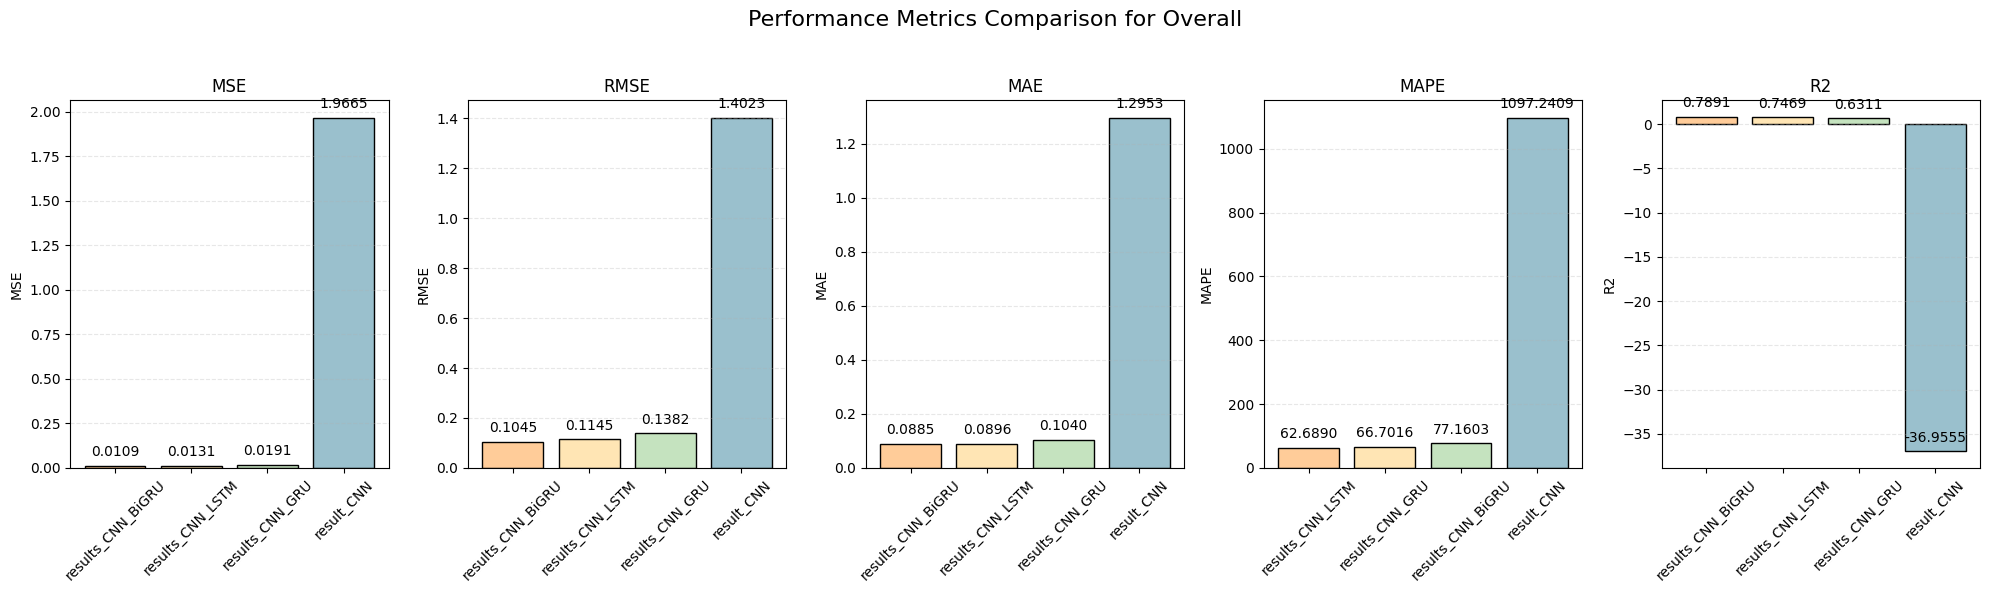

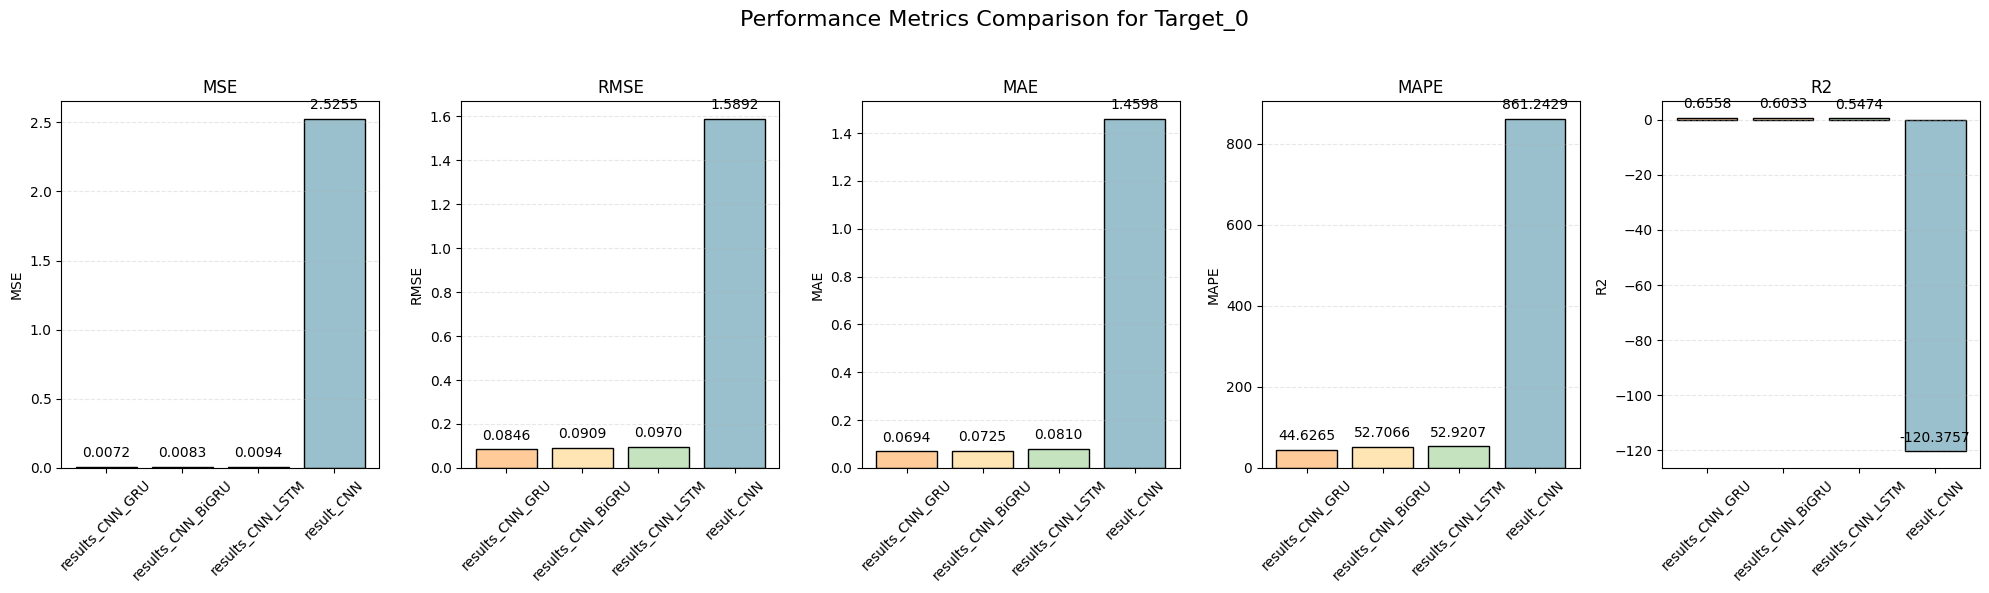

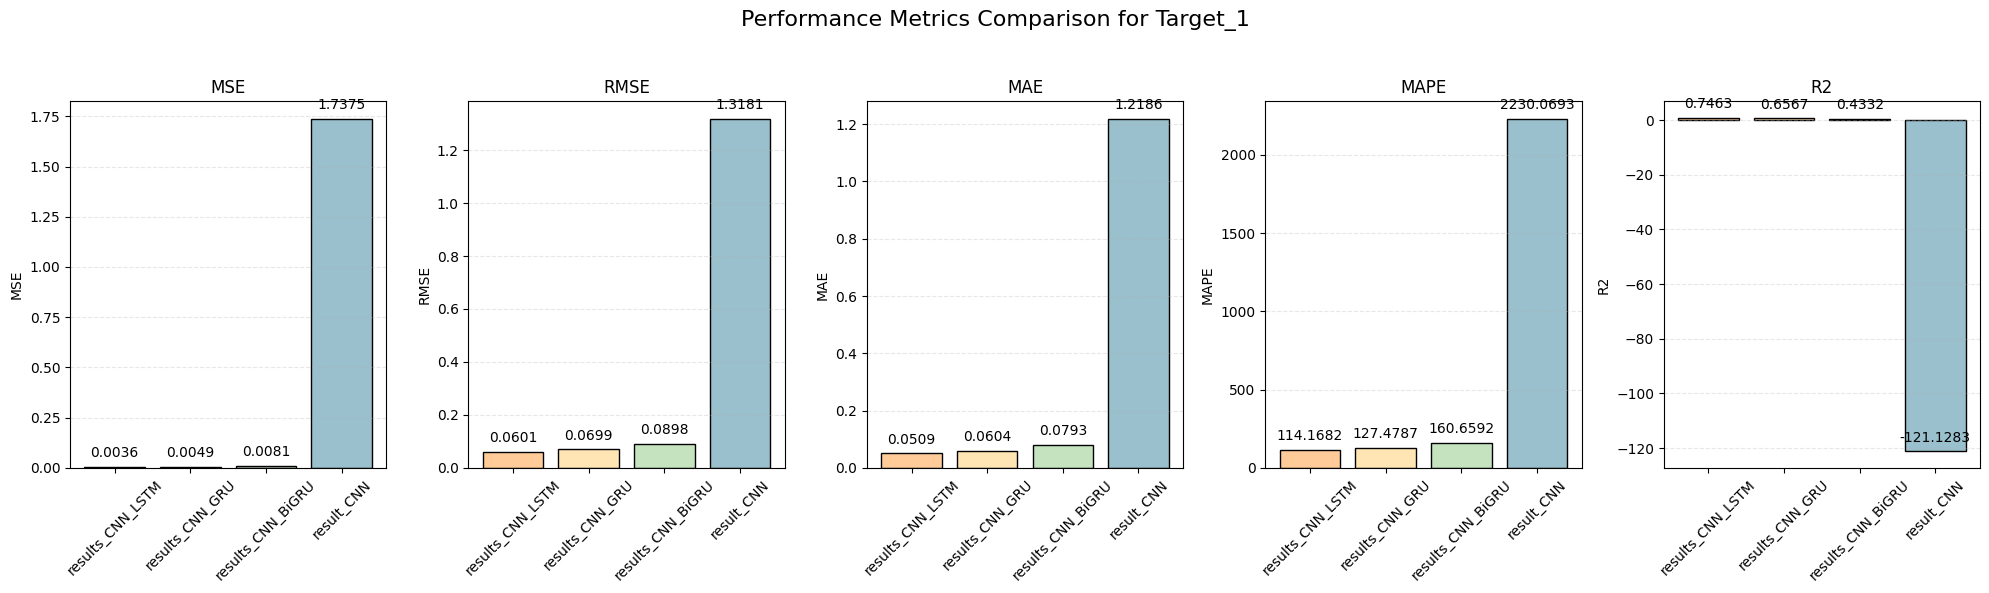

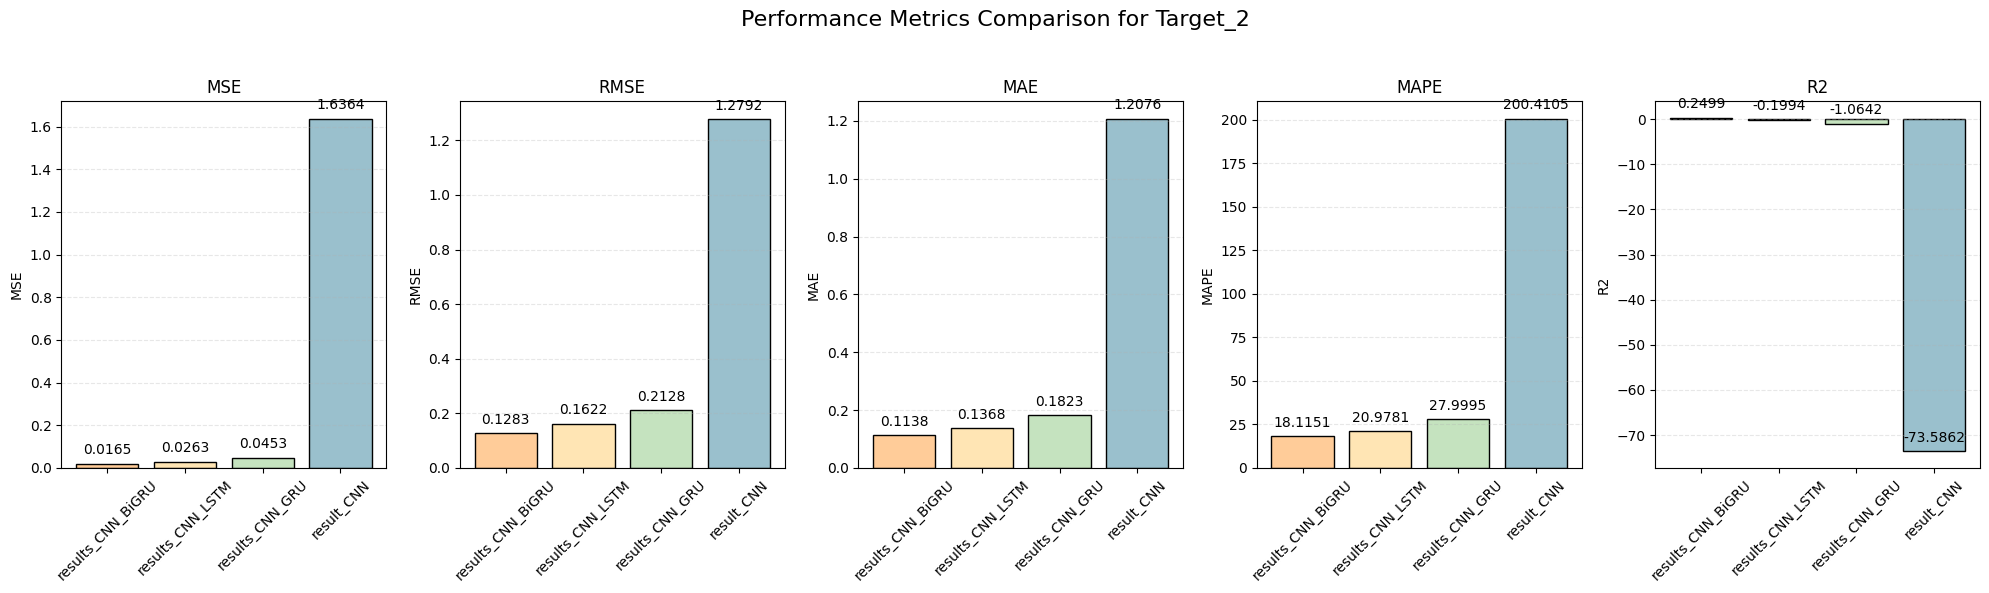

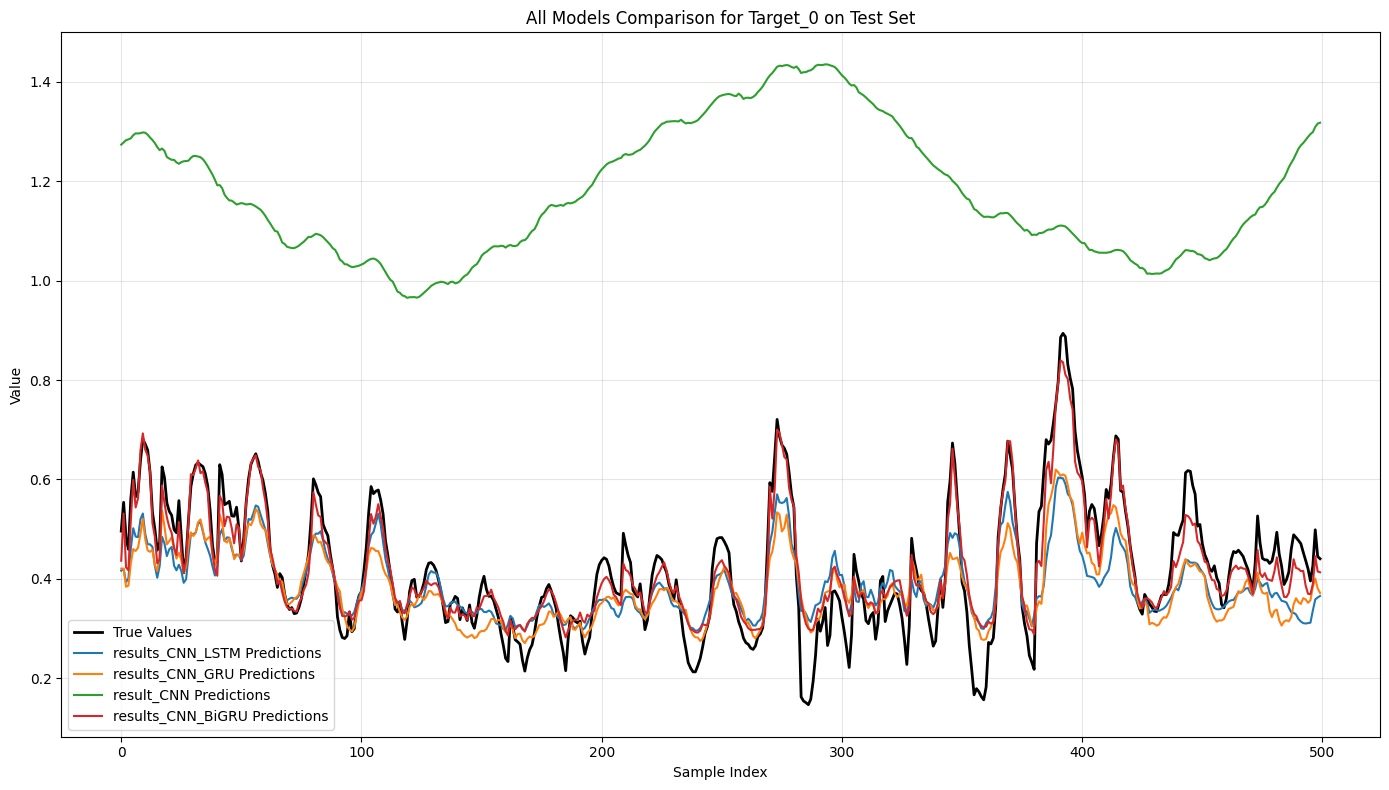

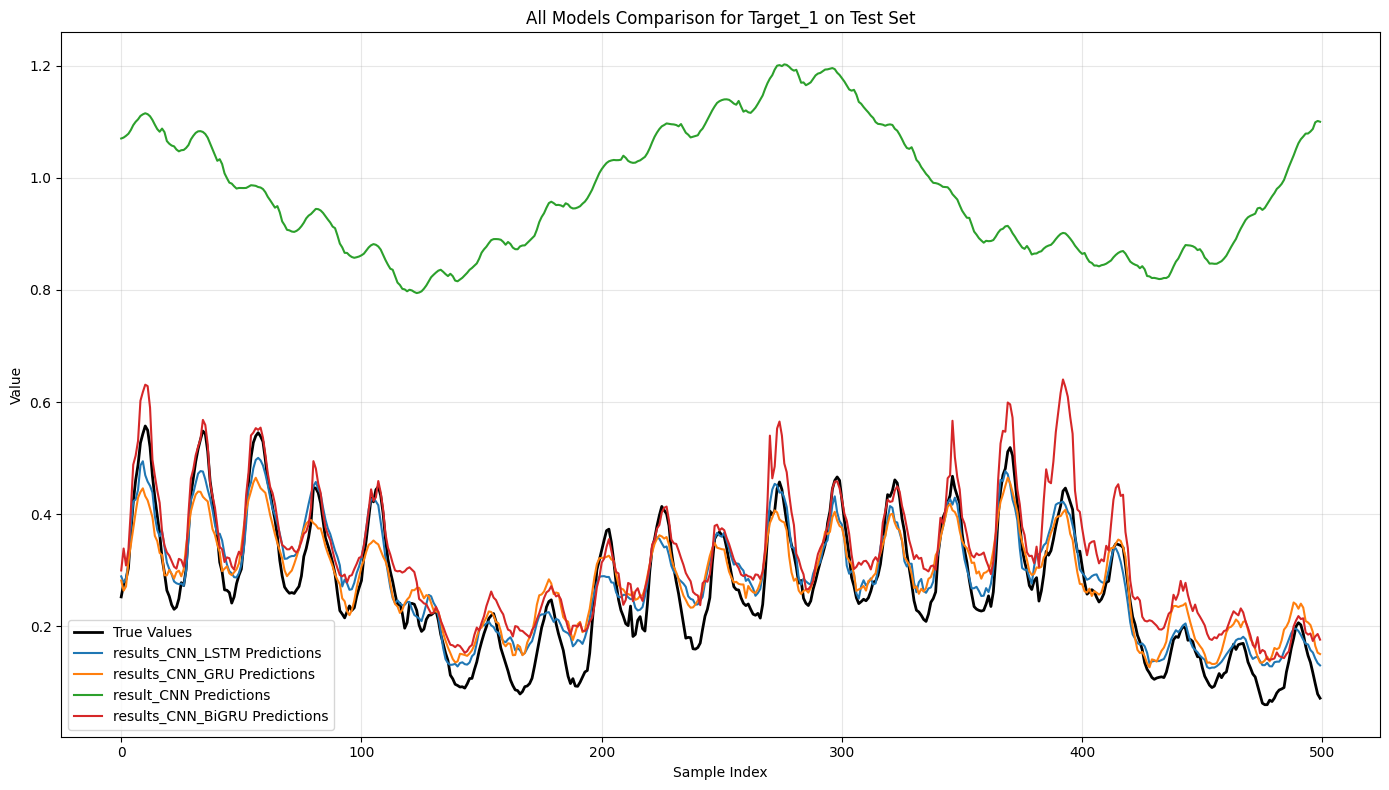

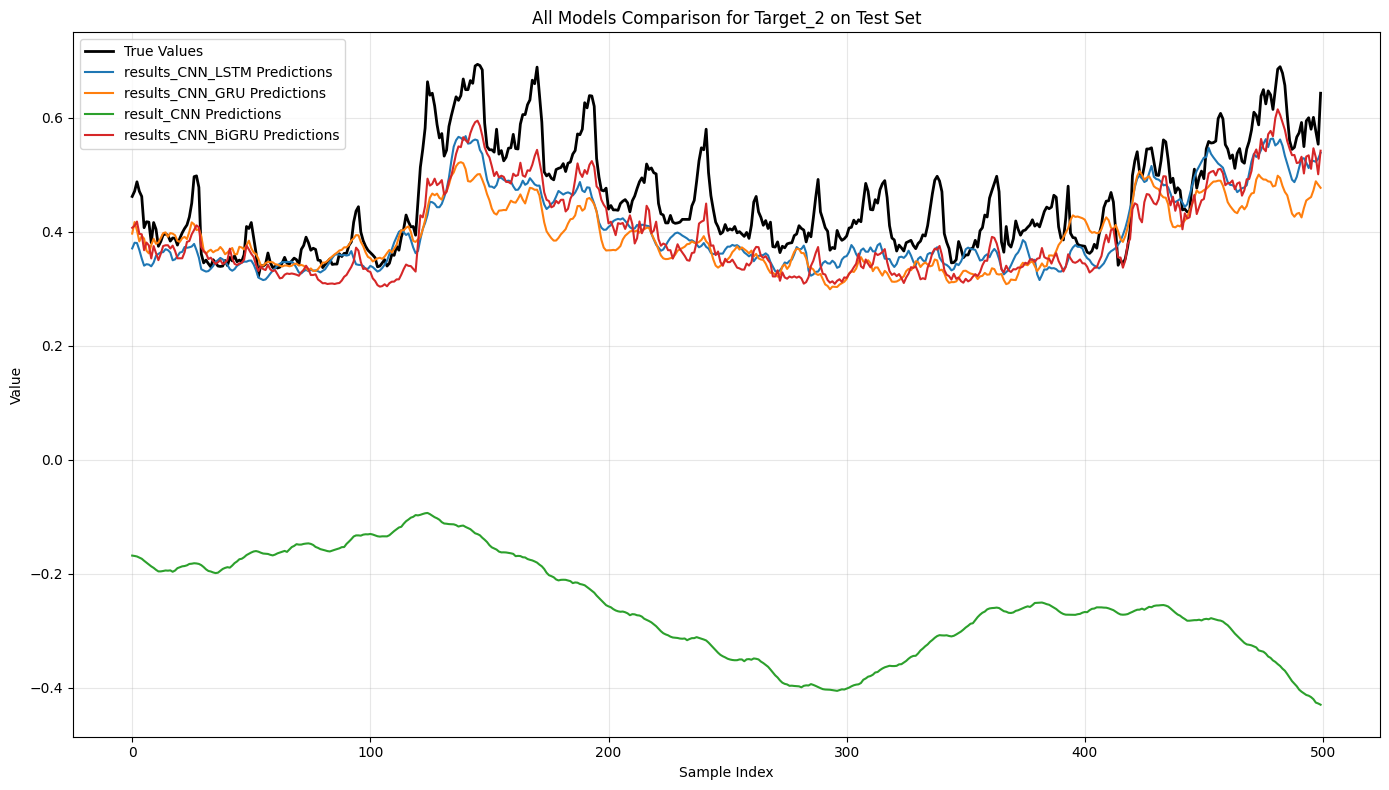

All visualizations complete. Metrics summary saved to /content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Introduction to Deep Learning/result/model_metrics_summary.xlsx


In [30]:
base_directory = r"/content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Introduction to Deep Learning/result"
main(base_directory)

## Results Analysis and Conclusions
1. Electric Load (Target 0)
  * CNN + LSTM performs best in predicting electric load, with an MSE of 0.0094, RMSE of 0.0970, MAE of 0.0810, and an R2 of 0.547, indicating the model's effectiveness in predicting and explaining variations in electric load.

  * CNN + GRU also performs well in predicting electric load, especially in terms of MAE and MAPE, outperforming the standalone CNN model.

  * The CNN standalone model performs poorly in electric load prediction, especially with high MSE and RMSE, suggesting its inability to make accurate predictions for this type of data.

  * CNN + BiGRU also performs well but slightly lags behind CNN + LSTM.

2. Cooling Load (Target 1)
  * CNN + LSTM performs the best for cooling load prediction, especially with a significant advantage in MAPE (114.17), indicating the model's high accuracy in forecasting cooling load and effectively capturing its changing patterns.

  * CNN + GRU also performs well in cooling load prediction, with relatively smaller MAPE and MAE, indicating the model's suitability for this task.

  * The CNN standalone model performs poorly in predicting cooling load, showing that CNN alone may not effectively handle the temporal characteristics of cooling load data.

  * CNN + BiGRU performs slightly worse than CNN + GRU and CNN + LSTM, but still shows potential advantages.

3. Heating Load (Target 2)
  * CNN + GRU performs the worst in predicting heating load, especially with high MSE and RMSE, indicating that this model may not capture sufficient information for accurate heating load prediction.

  * CNN + LSTM performs better in heating load prediction, although there are still some errors, but compared to other models, it delivers more accurate predictions.

  * The CNN standalone model performs the worst in predicting heating load, with a low R2 indicating that it fails to capture variations in heating load effectively.

  * CNN + BiGRU performs better than CNN + GRU for heating load prediction, particularly in terms of R2, providing better explanatory power.



## Conclusion
1. Best Model: CNN + LSTM
  * CNN + LSTM is the most effective model for predicting electric load, cooling load, and heating load. It performs excellently in all three targets, especially in MAPE and R2, making it the best choice.

2. Second Best Model: CNN + GRU
  * CNN + GRU also shows good performance, especially in predicting electric load and cooling load. However, its performance for heating load is worse than CNN + LSTM. This model requires fewer computational resources and can be a viable alternative.

3. CNN Standalone Model
  * The CNN standalone model performs poorly for predicting electric load and cooling load, and its performance for heating load is even worse. Thus, it is not the best choice for this task.

4. CNN + BiGRU
  * CNN + BiGRU performs slightly worse than CNN + LSTM but shows improvements for heating load prediction. It can capture bidirectional dependencies, making it beneficial in certain cases.

Based on the results, CNN + LSTM is the best model for energy load forecasting, effectively handling predictions for electric load, cooling load, and heating load.

## Model Improvement Suggestions
* Since CNN + BiGRU performs well in predicting thermal load, it can be further enhanced by integrating LSTM, leveraging its strength in capturing long-term dependencies. LSTM is proficient at handling long-term memory in time series, which helps better capture seasonal fluctuations and long-term trends in thermal load. Incorporating LSTM into the CNN + BiGRU architecture can improve the model's ability to recognize complex patterns and enhance the accuracy of thermal load predictions. This combination helps capture both short-term and long-term dependencies, strengthening the model's ability to predict changes across different time scales.